In [ ]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import astropy as ap
import pandas as pd
import astropy.cosmology as apc
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM

cosmo = FlatLambdaCDM(H0=100, Om0=0.3, Tcmb0=2.725) #std cosmo for that analysis

# Schechter Function

In [4]:
dfres = pd.read_csv('SDSS_DR8-test_results.csv')

In [5]:
dfsch = dfres[dfres['M_prodK_r'] < 30]
eventno = len(dfsch)

In [6]:
sch_c = 3*10**5 * u.km/u.s
schMr = dfsch['M_prodK_r']
schMr_l = schMr.min()
schMr_u = schMr.max()

sch_z = dfsch['redshift']
sch_z_max = sch_z.max()
sch_z_min = sch_z.min()

sch_L = np.exp(-0.4*schMr)
#E_func = np.sqrt(cosmo.Ode0 + cosmo.Ok0 * (1+sch_z)**2 + cosmo.Om0 * (1+sch_z)**3)
sch_dl = cosmo.luminosity_distance(sch_z)

Defining the the comoving volume function (Eales 1993)

In [90]:
def V(x):
    return ((1+x)**2 * np.sqrt(cosmo.Ode0 + cosmo.Ok0 * (1+x)**2 + cosmo.Om0 * (1+x)**3))**(-1)

In [8]:
integ,_ = sp.integrate.quad(lambda x:V(x), sch_z_min,sch_z_max)

In [ ]:
V_max = 4946*sch_c*sch_dl**2/cosmo.H0 * integ #4946 is a placeholder value from DES, it's the total surveyed sky area
V_inv = V_max**-1

In [137]:
phi = V_inv.sum()*5/(2*np.log(10))*u.Mpc**3

Defining the luminosity function

In [138]:
from scipy.optimize import curve_fit

def func(x, M_star, alpha):
    return 0.4*np.log(10)*phi*10**(-0.4*(1+alpha)*(x-M_star))*np.exp(-1*(10)**(-0.4*(x-M_star)))

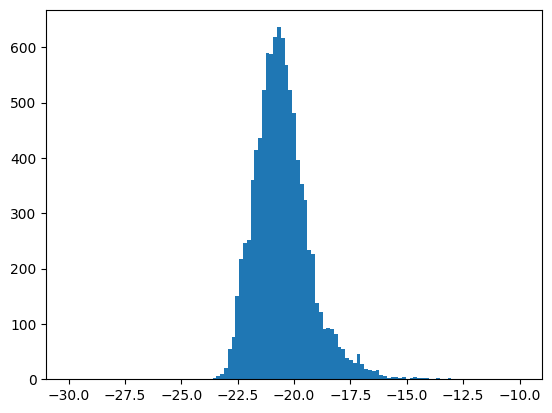

In [148]:
zxcvb = plt.hist(schMr,bins=np.linspace(-30,-10,120))

In [140]:
counts, edges = np.histogram(schMr, bins=np.linspace(-30,-10,100000))
optedges = 0.5*(edges[1:]+edges[:-1])
coeffs, cov = curve_fit(func, optedges, counts, p0=[-21, 0.1])

/tmp/ipykernel_12607/3892862343.py:4: RuntimeWarning: overflow encountered in power
  return 0.4*np.log(10)*phi*10**(-0.4*(1+alpha)*(x-M_star))*np.exp(-1*(10)**(-0.4*(x-M_star)))


In [141]:
coeffs, cov

(array([-20.55419993,  -0.52703802]),
 array([[2.74419991e+10, 1.12204649e+10],
        [1.12204649e+10, 1.13992476e+10]]))

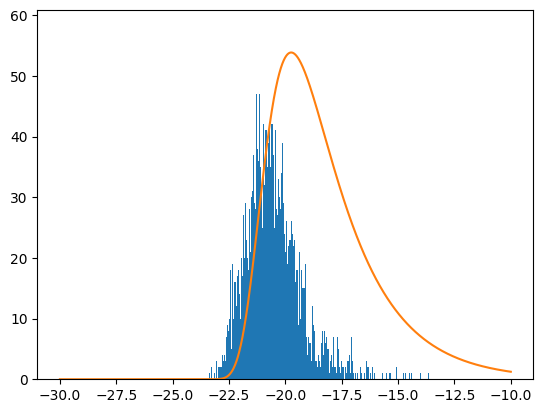

In [153]:
zxcvb = plt.hist(schMr,bins=np.linspace(-30,-10,2000))
plt.plot(optedges, 10**9*func(optedges,*coeffs))

In [145]:
sp.integrate.quad(lambda x: func(x,*coeffs),schMr_l,schMr_u)*V_inv.sum()**-1*u.Mpc**-3

<Quantity [1.97481602, 0.00642003]>